In [1]:
%load_ext autoreload
%autoreload 2


from deep_bf.data_handler import DataLoader, rf2iq

dl = DataLoader("../../../rf_data")
# print(dl.df.head())

pw = dl.get_defined_pwdata("contrast_speckle_expe_dataset_rf", "RF")
# print(test.data.shape)
# print(test.fc, test.fs)

fs = pw.fs
fc = pw.fc

rf = pw.data
print(rf.shape)

#iq = rf2iq(rf, fs, fc)
#print(iq.shape)

(75, 128, 3328)


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDAS(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.nz, self.nx = output_size

    def forward(self, rf, delays):
        b, n_ch, n_samp = rf.shape

        x_folded = rf.reshape(b*n_ch, 1, 1, n_samp)
        delays_folded = delays.reshape(b*n_ch, self.nz, self.nx)

        #delays_folded = delays_folded.float()

        grid_x = 2.0 * (delays_folded / (n_samp -1)) - 1.0
        grid_y = torch.zeros_like(grid_x)
        grid = torch.stack((grid_x, grid_y), dim=-1)
        grid = grid.to(torch.float16)

        sampled = F.grid_sample(
            x_folded,
            grid,
            mode="bilinear",
            padding_mode="zeros",
            align_corners=True,
        )

        sampled = sampled.view(b, n_ch, self.nz, self.nx)
        das = torch.sum(sampled, dim=1)

        return das

In [ ]:
class SimpleDAS2(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.nz, self.nx = output_size

    def forward(self, rf, delays):
        b, n_ch, n_samp = rf.shape

        x_folded = rf.reshape(b*n_ch, 1, 1, n_samp)
        delays_folded = delays.reshape(b*n_ch, self.nz, self.nx)

        #delays_folded = delays_folded.float()

        grid_x = 2.0 * (delays_folded / (n_samp -1)) - 1.0
        grid_y = torch.zeros_like(grid_x)
        grid = torch.stack((grid_x, grid_y), dim=-1)
        grid = grid.to(torch.float16)

        sampled = F.grid_sample(
            x_folded,
            grid,
            mode="bilinear",
            padding_mode="zeros",
            align_corners=True,
        )

        sampled = sampled.view(b, n_ch, self.nz, self.nx)
        das = torch.sum(sampled, dim=1)

        return das

In [82]:
class DifferentiableBMode(nn.Module):
    def __init__(self, dynamic_range=60, gain_db=0):
        super().__init__()
        self.dr = dynamic_range
        self.gain = gain_db
        self.min_signal = 1e-9 # Piso para evitar log(0)

    def forward(self, iq_sum):
        # iq_sum: [Batch, 2, Z, X]
        
        # 1. Envelope (Norma Euclidiana robusta)
        env = torch.norm(iq_sum, dim=1, keepdim=True)
        env = torch.clamp(env, min=self.min_signal)
        
        # 2. Log Compression
        env_db = 20 * torch.log10(env)
        
        # 3. Robust Normalization (Evita flickering)
        # Usamos el máximo de la imagen como referencia (0 dB)
        batch, ch, h, w = env_db.shape
        flat = env_db.view(batch, ch, -1)
        ref_val = flat.max(dim=-1, keepdim=True).values.view(batch, ch, 1, 1)
        
        # .detach() evita que la red aprenda a apagar el brillo global
        env_norm = env_db - ref_val.detach() + self.gain
        
        # 4. Range Mapping
        image = (env_norm + self.dr) / self.dr
        return torch.clamp(image, 0, 1)

In [9]:
import torch

class VRAMMonitor:
    def __init__(self, label="Bloque"):
        self.label = label
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def __enter__(self):
        if self.device.type == 'cuda':
            # Sincronizar para asegurar que todo lo anterior terminó
            torch.cuda.synchronize()
            # Resetear el contador de "pico máximo" para medir solo este bloque
            torch.cuda.reset_peak_memory_stats()
            
            self.before_allocated = torch.cuda.memory_allocated()
            self.before_reserved = torch.cuda.memory_reserved()
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        if self.device.type == 'cuda':
            torch.cuda.synchronize()
            
            # Memoria actual (al terminar el bloque)
            current_allocated = torch.cuda.memory_allocated()
            current_reserved = torch.cuda.memory_reserved()
            
            # Pico máximo alcanzado DURANTE el bloque
            peak_allocated = torch.cuda.max_memory_allocated()
            
            print(f"\n--- 📊 VRAM Report: {self.label} ---")
            print(f"   Inicio:    {self.format_bytes(self.before_allocated)}")
            print(f"   Final:     {self.format_bytes(current_allocated)}")
            print(f"   Diferencia:{self.format_bytes(current_allocated - self.before_allocated)}")
            print(f"   🚀 PICO:   {self.format_bytes(peak_allocated)} (Máximo usado internamente)")
            print("-----------------------------------")
            
    @staticmethod
    def format_bytes(size):
        # Convierte bytes a MiB o GiB
        power = 1024
        n = 0
        power_labels = {0 : '', 1: 'KiB', 2: 'MiB', 3: 'GiB', 4: 'TiB'}
        while size > power:
            size /= power
            n += 1
        return f"{size:.2f} {power_labels[n]}"

In [3]:
import numpy as np

def compute_das_delays(pw, nz=1024, nx=512, dtype=np.float16):
    """
    Calcula retardos DAS optimizado para memoria RAM limitada.
    Calcula ángulo por ángulo para evitar el pico de memoria de 32GB+.
    
    Args:
        pw: Objeto PWData cargado.
        nz, nx: Resolución de imagen.
        dtype: np.float16 reduce el tamaño total a ~10GB (recomendado).
               np.float16 sube a ~20GB (peligroso en sistemas de 32GB RAM).
    """
    n_angles = pw.n_angles
    n_ch = pw.n_channels
    fs = pw.fs
    c0 = pw.c0
    
    # 1. Pre-allocar la memoria final (vacía)
    # Shape PyTorch friendly: (Angles, Channels, Z, X)
    print(f"Allocando memoria para retardos: {n_angles}x{n_ch}x{nz}x{nx}...")
    delays_all = np.empty((n_angles, n_ch, nz, nx), dtype=dtype)
    
    # 2. Configurar Grid Espacial (Común para todos)
    z = np.linspace(pw.zlims[0], pw.zlims[-1], nz, dtype=np.float16)
    x = np.linspace(-pw.aperture_width/2, pw.aperture_width/2, nx, dtype=np.float16)
    Z, X = np.meshgrid(z, x, indexing='ij') # (nz, nx)
    
    # 3. Calcular RX (Recepción) - Se calcula UNA sola vez
    # (nz, nx, n_ch) ~ 260 MB (Manejable)
    ele_pos = pw.probe_geometry[:, 0].astype(np.float16)
    
    # Broadcasting RX: [Nz, Nx, 1] - [1, 1, Ch]
    d_rx = np.sqrt((X[..., np.newaxis] - ele_pos)**2 + Z[..., np.newaxis]**2)
    t_rx = d_rx / c0
    
    # Expandir t_rx para sumar luego: (1, nz, nx, n_ch) -> (n_ch, nz, nx) para transponer
    # Para ahorrar memoria, mantenemos (nz, nx, n_ch) y transponemos al final del loop.
    
    print("Calculando ángulos iterativamente...")
    
    # 4. Bucle sobre Ángulos (Evita explosión de RAM)
    angles = pw.angles.astype(np.float16)
    t0_vals = pw.t0 if np.ndim(pw.t0) > 0 else np.full(n_angles, pw.t0)

    for i in range(n_angles):
        angle = angles[i]
        t0 = t0_vals[i]
        
        # --- TX (Transmisión) para ángulo 'i' ---
        # d_tx = x*sin(a) + z*cos(a)
        # Shape: (nz, nx) -> Muy pequeño
        sin_a = np.sin(angle)
        cos_a = np.cos(angle)
        d_tx = X * sin_a + Z * cos_a
        t_tx = d_tx / c0
        
        # --- Suma Total (TX + RX - t0) ---
        # t_tx: (nz, nx, 1) [broadcasting virtual]
        # t_rx: (nz, nx, n_ch)
        # Resultado temporal: (nz, nx, n_ch)
        
        # Hacemos la suma y conversión a muestras en un paso
        # total_seconds = (t_tx[..., None] + t_rx) - t0
        # samples = total_seconds * fs
        
        # Optimización numérica:
        delay_slice = (t_tx[..., np.newaxis] + t_rx - t0) * fs
        
        # --- Transposición y Guardado ---
        # Numpy produce (nz, nx, n_ch).
        # Queremos (n_ch, nz, nx) para guardar en delays_all[i].
        
        # Transponer (2, 0, 1) mueve n_ch al principio
        delays_all[i] = np.transpose(delay_slice, (2, 0, 1)).astype(dtype)
        
        # Feedback visual cada 10 ángulos
        if i % 10 == 0:
            print(f"  > Ángulo {i}/{n_angles} procesado.")

    print("Cálculo finalizado.")
    return delays_all

delays = compute_das_delays(pw, nz=1024, nx=512, dtype=np.float16)

Allocando memoria para retardos: 75x128x1024x512...
Calculando ángulos iterativamente...
  > Ángulo 0/75 procesado.
  > Ángulo 10/75 procesado.
  > Ángulo 20/75 procesado.
  > Ángulo 30/75 procesado.
  > Ángulo 40/75 procesado.
  > Ángulo 50/75 procesado.
  > Ángulo 60/75 procesado.
  > Ángulo 70/75 procesado.
Cálculo finalizado.


In [4]:
delays.shape

(75, 128, 1024, 512)

In [5]:
model = SimpleDAS(output_size=(1024, 512)).cuda()
#post_proc = DifferentiableBMode(dynamic_range=50).cuda()

In [11]:
idx = pw.n_angles // 2
#idx = 7

with VRAMMonitor("Inferencia DAS"):
    delays_tensor = torch.from_numpy(delays[idx, ...]).float().unsqueeze(0).cuda()
    rf_tensor = torch.from_numpy(rf[idx, ...]).type(torch.float16).unsqueeze(0).cuda()
    rf_das = model(rf_tensor, delays_tensor)
    #b_mode = post_proc(iq_das)

rf_das = rf_das.squeeze()


--- 📊 VRAM Report: Inferencia DAS ---
   Inicio:    257.81 MiB
   Final:     257.81 MiB
   Diferencia:0.00 
   🚀 PICO:   1.50 GiB (Máximo usado internamente)
-----------------------------------


In [10]:
idx = pw.n_angles // 2
#idx = 7

with VRAMMonitor("Inferencia DAS"):
    with torch.no_grad():
        delays_tensor = torch.from_numpy(delays[idx, ...]).float().unsqueeze(0).cuda()
        rf_tensor = torch.from_numpy(rf[idx, ...]).type(torch.float16).unsqueeze(0).cuda()
        rf_das = model(rf_tensor, delays_tensor)
        #b_mode = post_proc(iq_das)

rf_das = rf_das.squeeze()


--- 📊 VRAM Report: Inferencia DAS ---
   Inicio:    257.81 MiB
   Final:     257.81 MiB
   Diferencia:0.00 
   🚀 PICO:   1.50 GiB (Máximo usado internamente)
-----------------------------------


In [8]:
print(rf_das.shape)
#print(rf_das[0,...])



torch.Size([1024, 512])


In [7]:
from scipy.signal import hilbert

env = hilbert(rf_das.cpu().numpy(), axis=0)
b_mode = 20 * np.log10(np.abs(env) + 1e-10)
b_mode -= np.amax(b_mode)

4. Visualizando...


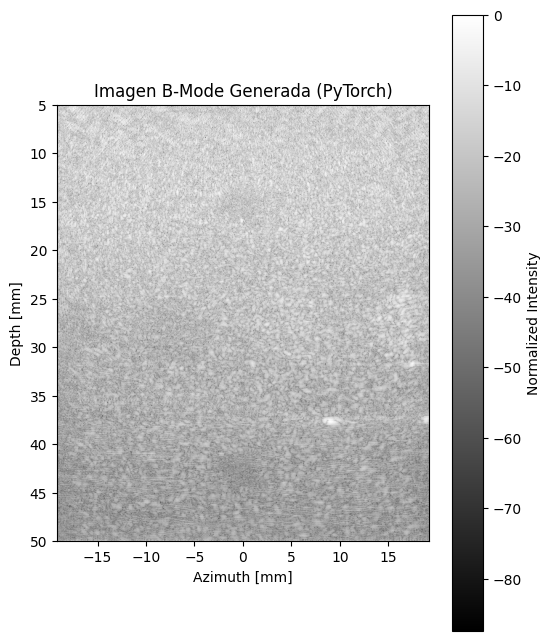

In [8]:
import matplotlib.pyplot as plt

z = np.linspace(pw.zlims[0], pw.zlims[-1], 1024, dtype=np.float32)
x = np.linspace(-pw.aperture_width/2, pw.aperture_width/2, 512, dtype=np.float32)
Z, X = np.meshgrid(z, x, indexing='ij') # (nz, nx)
Y = X * 0
grid = np.stack((X, Y, Z), axis=-1, dtype=np.float32)

zlims = grid[:, 0, 2] * 1e3
xlims = grid[0, :, 0] * 1e3


# --- E. VISUALIZACIÓN ---
print("4. Visualizando...")
#img_np = b_mode.squeeze().cpu().numpy()

plt.figure(figsize=(6, 8))
plt.imshow(b_mode, cmap='gray', extent=(xlims[0], xlims[-1], zlims[-1], zlims[0]))
plt.title("Imagen B-Mode Generada (PyTorch)")
plt.xlabel("Azimuth [mm]")
plt.ylabel("Depth [mm]")
plt.colorbar(label="Normalized Intensity")
plt.show()

In [ ]:
gb_size = delays.nbytes / (1024**3)
print(f"Tamaño: {gb_size:.4f} GB")

Tamaño: 9.3750 GB


: 